Potrzebne biblioteki

In [3]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
from random import sample

from skimage import filters
from sklearn.neighbors import KNeighborsClassifier
import pickle
import time

import cv2
import copy

import joblib
import numpy as np
import matplotlib.pyplot as plt
from random import sample
from PIL import Image
from skimage import filters
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from scipy import stats
import cv2
from sklearn.preprocessing import StandardScaler

Porównanie przetworzonego obrazu z oczekiwanym

In [5]:
def confusion_matrix(predicted_image, expected_image):
    white = (255, 255, 255)
    red = (255, 0, 0)
    green = (0, 255, 0)
    purple = (255, 0, 255)
    conf_matrix = np.array(predicted_image.shape[:2])
    result_array = []
    for i in range(predicted_image.shape[0]):
        result_row = []
        for j in range(predicted_image.shape[1]):
            if predicted_image[i, j] and expected_image[i, j]:
                result_row.append(green)
                # conf_matrix[i, j] = green  # Green
            elif predicted_image[i, j] and not expected_image[i, j]:
                result_row.append(red)
                # conf_matrix[i, j] = red  # Red
            elif not predicted_image[i, j] and expected_image[i, j]:
                result_row.append(purple)
                # conf_matrix[i, j] = purple  # Purple
            else:
                result_row.append(white)
                # conf_matrix[i, j] = white  # White
        result_array.append(result_row)

    return np.array(result_array)

Wyliczenie statystyk porównania obrazu z maską ekspercką

In [28]:
def image_metrics(predicted, model):
    assert predicted.shape == model.shape, "Predicted and model arrays must have the same shape."

    true_positive = np.sum((predicted > 0) & (model > 0))
    false_positive = np.sum((predicted > 0) & (model == 0))
    false_negative = np.sum((predicted == 0) & (model > 0))
    true_negative = np.sum((predicted == 0) & (model == 0))
    total = true_positive + false_positive + false_negative + true_negative
    accuracy = round(((true_positive + true_negative) / total) * 100, 6)

    sensitivity = round((true_positive / (true_positive + false_negative + 1)) * 100, 6)
    specificity = round((true_negative / (true_negative + false_positive + 1)) * 100, 6)
    mean_sensitivity_specificity = round((sensitivity + specificity) / 2, 6)

    print(f"True positive: {true_positive}\t False positive: {false_positive}")
    print(f"Accuracy: {accuracy}%")
    print(f"Sensitivity: {sensitivity}%")
    print(f"Specificity: {specificity}%")
    print(f"Mean Sensitivity-Specificity: {mean_sensitivity_specificity}%")


Wymagania na 3

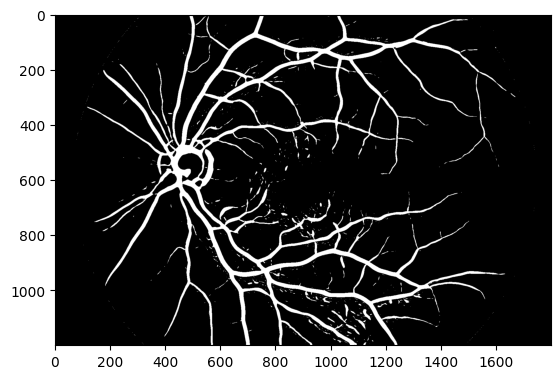

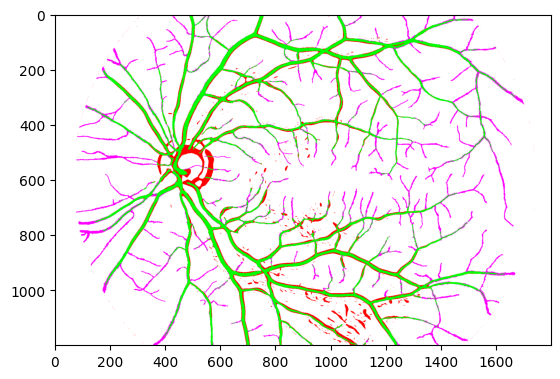

True positive: 137084	 False positive: 54777
Accuracy: 94.067963%
Sensitivity: 65.141608%
Specificity: 97.190241%
Mean Sensitivity-Specificity: 81.165924%


In [37]:
image_number = "14"
image = cv2.imread(f'images/{image_number}_h.jpg')
mask = cv2.imread(f'healthy_fovmask/{image_number}_h_mask.tif')
expected_result = cv2.imread(f'healthy_manualsegm/{image_number}_h.tif')

desired_width = 1800
desired_height = 1200

image_2 = cv2.resize(copy.deepcopy(image), (desired_width, desired_height))
mask = cv2.resize(mask, (desired_width, desired_height))
expected_result = cv2.resize(expected_result, (desired_width, desired_height))


expected_result = expected_result[:, :, 1]
green_channel_image = image_2[:, :, 1]
green_channel_mask = mask[:, :, 1]

green_channel_image[green_channel_mask == 0] = 0

image_copy = copy.deepcopy(green_channel_image)

blurred_image = filters.unsharp_mask(image_copy)
sato = filters.sato(blurred_image)
sato[green_channel_mask == 0] = 0
threshold_value = 0.014
predicted_image = ((sato > threshold_value).astype(int) * 255)

plt.imshow(predicted_image, cmap='gray')
plt.show()
normalized_image = (predicted_image / np.max(predicted_image)) * 255
pil_image_predicted = Image.fromarray(normalized_image)
pil_image_predicted = pil_image_predicted.convert('L')
pil_image_predicted.save("predicted_filter.png")

differences = confusion_matrix(predicted_image, expected_result)
plt.imshow(differences)
plt.show()
differences = np.array(differences)
pil_image = Image.fromarray(differences.astype(np.uint8))
pil_image.save("differences_filter.png")
image_metrics(predicted_image, expected_result)

Podział obrazu na wycinki

In [17]:
def split_image_into_patches(input_image, patch_size=5):
    height, width = input_image.shape[0], input_image.shape[1]
    patches = []
    for i in range(0, height - patch_size + 1, patch_size):
        for j in range(0, width - patch_size + 1, patch_size):
            patch = input_image[i:i + patch_size, j:j + patch_size]
            patches.append(patch)
    return patches

Podział maski eksperckiej na wycinki

In [16]:
def extract_middle_pixel(input_image, patch_size=5):
    height, width = input_image.shape[0], input_image.shape[1]
    piece = patch_size // 2
    pixels = []
    for i in range(piece, height - piece, patch_size):
        for j in range(piece, width - piece, patch_size):
            pixel = int(input_image[i, j])
            pixels.append(pixel)
    return pixels

Ekstrakcja cech wycinka

In [15]:
def extract_image_features(flat_patch):
    moments = [np.mean(flat_patch), np.var(flat_patch), np.mean(np.power(flat_patch - np.mean(flat_patch), 3))]
    image_moments = cv2.moments(flat_patch).values()
    hu_moments = cv2.HuMoments(cv2.moments(flat_patch)).flatten()
    features = [*moments, *image_moments, *hu_moments]

    return features

Trening danych

In [43]:
study_set = ['01_h', '02_h', '03_h', '04_h']

all_dataset = []
mask_pixels = []
for i, image_path in enumerate(study_set):
    set = []
    image_2 = cv2.imread(f'images/{image_path}.jpg')
    mask = cv2.imread('healthy_fovmask/01_h_mask.tif')
    expected_result_mask = cv2.imread(f'healthy_manualsegm/{image_path}.tif')
    desired_width = 1750
    desired_height = 1150

    image_2 = cv2.resize(copy.deepcopy(image_2), (desired_width, desired_height))
    mask = cv2.resize(mask, (desired_width, desired_height))
    expected_result_mask = cv2.resize(expected_result_mask, (desired_width, desired_height))

    green_channel_image = image_2[:, :, 1]
    expected_result = expected_result_mask[:, :, 1]
    image_contrasted = cv2.equalizeHist(green_channel_image)

    patches = split_image_into_patches(image_contrasted)

    result_patches_pixels = extract_middle_pixel(expected_result)
    
    for patch in patches:
        flat_patch = patch.flatten().astype(float)
        features = extract_image_features(flat_patch)
        set.append(list(flat_patch) + features)

    all_dataset.extend(set)
    mask_pixels.extend(result_patches_pixels)

x_train, x_test, y_train, y_test = train_test_split(all_dataset, mask_pixels, test_size=0.3)

scaler = StandardScaler()
x_train_transformed = scaler.fit_transform(x_train)
x_test_transformed = scaler.transform(x_test,)

classifier = RandomForestClassifier(n_estimators=300, n_jobs=-1)
classifier.fit(x_train_transformed, y_train)

y_predicted = classifier.predict(x_test_transformed)

accuracy_result = accuracy_score(y_test, y_predicted)
print(f"Accuracy Score: {accuracy_result}")

joblib.dump(scaler, 'scaler.bin', compress=3)
joblib.dump(classifier, 'classifier.pkl', compress=3)

Accuracy Score: 0.9413146997929607


['classifier.pkl']

Przetworzenie obrazu przez klasyfikator

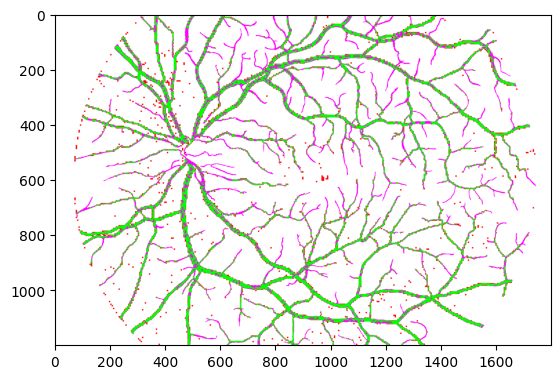

True positive: 148600	 False positive: 40300
Accuracy: 93.424167%
Sensitivity: 59.359509%
Specificity: 97.889628%
Mean Sensitivity-Specificity: 78.624569%


In [45]:
classifier = joblib.load('classifier.pkl')
scaler = joblib.load('scaler.bin')

image_number = "12"
image_2 = cv2.imread(f'images/{image_number}_h.jpg')
mask = cv2.imread(f'healthy_fovmask/{image_number}_h_mask.tif')
expected_result_mask = cv2.imread(f'healthy_manualsegm/{image_number}_h.tif')

desired_width = 1800
desired_height = 1200
image_2 = cv2.resize(copy.deepcopy(image_2), (desired_width, desired_height))



green_channel_image = image_2[:, :, 1]
green_channel_mask = mask[:, :, 1]
expected_result_mask = expected_result_mask[:, :, 1]

expected_result_mask = cv2.resize(expected_result_mask, (desired_width , desired_height ))

image_contrasted = cv2.equalizeHist(green_channel_image)

patches = split_image_into_patches(image_contrasted)


image_dataset = []
for patch in patches:
    flat_patch = patch.flatten().astype(float)
    features = extract_image_features(flat_patch)
    image_dataset.append(list(flat_patch) + features)

x_test_transformed = scaler.transform(image_dataset)

predicted_image = classifier.predict(x_test_transformed)

height, width, channels = image_2.shape
new_image = np.zeros((height, width ))

for x in range(0, height, 5):
    for y in range(0, width, 5):
        new_image[x:x+5, y:y+5] = predicted_image[0]
        predicted_image = predicted_image[1:]


normalized_image = (new_image / np.max(new_image)) * 255

pil_image = Image.fromarray(normalized_image)
pil_image = pil_image.convert('L')
pil_image.save("predicted_machine.png")

differences = confusion_matrix(normalized_image, expected_result_mask)
plt.imshow(differences)
plt.show()

differences = np.array(differences)
pil_differences = Image.fromarray(differences.astype(np.uint8))
pil_differences.save("differences_machine.png")


image_metrics(normalized_image, expected_result_mask)
# pil_differences.show()